In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-09-15T19:05:19.508597+03:00

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.21.0

Compiler    : GCC 14.2.1 20240817
OS          : Linux
Release     : 6.10.10-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [2]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [3]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)
        area = requests.get(
            f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-09-14: 100%|██████████| 1039/1039 [03:26<00:00,  5.03it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
5338,#ff5252,139991.513798,23.189,other_territories,2024-09-14 15:25:20
5339,#880e4f,43974.128584,7.284,occupied_to_24_02_2022,2024-09-14 15:25:20
5340,#a52714,66016.688743,10.935,occupied_after_24_02_2022,2024-09-14 15:25:20
5341,#bdbdbd,351.628610,0.058,other_territories,2024-09-14 15:25:20


In [4]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [5]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [6]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [7]:
df

,hash,area,percent,type
time_index,,,,
2022-04-03 15:33:28,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
2022-04-03 15:33:28,#880e4f,46937.208199,7.775000,occupied_to_24_02_2022
2022-04-03 15:33:28,#bcaaa4,5587.522472,0.926000,unspecified
2022-04-03 15:33:28,#0f9d58,14012.882652,2.321000,liberated
2022-04-03 19:46:15,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
...,...,...,...,...
2024-09-14 15:25:20,#ff5252,139991.513798,23.188999,other_territories
2024-09-14 15:25:20,#880e4f,43974.128584,7.284000,occupied_to_24_02_2022
2024-09-14 15:25:20,#a52714,66016.688743,10.935000,occupied_after_24_02_2022


In [8]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_16380/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [9]:
occupied_by_ua = (
    df[
        (df["type"] == "other_territories") &
        (df['hash'] == '#01579b')
    ]
    .groupby(pd.Grouper(freq="D"))[["area", "percent"]]
    .mean()
    .fillna(0)
)
occupied_by_ua

,area,percent
time_index,,
2024-08-08,142.989574,0.024
2024-08-09,142.989574,0.024
2024-08-10,142.989574,0.024
2024-08-11,142.989574,0.024
2024-08-12,313.306949,0.052
2024-08-13,313.483165,0.052
2024-08-14,469.022292,0.078
2024-08-15,507.762966,0.084
2024-08-16,532.395801,0.088


In [10]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-09-14                    liberated
2024-09-14    occupied_after_24_02_2022
2024-09-14       occupied_to_24_02_2022
2024-09-14            other_territories
2024-09-14                  unspecified
Name: type, Length: 4049, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [11]:
area_dinamic["type"].unique()

['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'unspecified', 'other_territories']
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [12]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [13]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [14]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-09-10,65936.863690,0
2024-09-11,65978.351483,0
2024-09-12,65992.579919,0
2024-09-13,66004.634331,0


In [15]:
aa['area'] = aa['area'].subtract(occupied_by_ua['area'], fill_value=0)
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-09-10,65029.254117,0
2024-09-11,65091.699226,0
2024-09-12,65105.927161,0
2024-09-13,66004.634331,0


In [16]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     763.2
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:08:50   Log-Likelihood:                -8216.8
No. Observations:                 896   AIC:                         1.645e+04
Df Residuals:                     889   BIC:                         1.648e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)   890.1028    136.674      6.513      0.000     621.862    1158.344
cos(1,730.50)  2697.9396    209.377     12.886      0.000    2287.009    3108.871
sin(2,730.50)  2319.6768    131.903     17.586      0.000    2060.800    2578.554
cos(2,730.50)  -612.0503    129.785     -4.716      0.000    -866.770    -357.330
prefix         3077.5052    598.156      5.145      0.000    1903.542    4251.468
const          7.172e+04    506.012    141.741      0.000    7.07e+04    7.27e+04
trend           -12.1217      0.878    -13.813      0.000     -13.844     -10.399
==============================================================================
Omnibus:                      336.419   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2512.439
Skew:                          -1.515   Prob(JB):                         0.00
Kurtosis:                      10.624   Cond. No.                     5.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

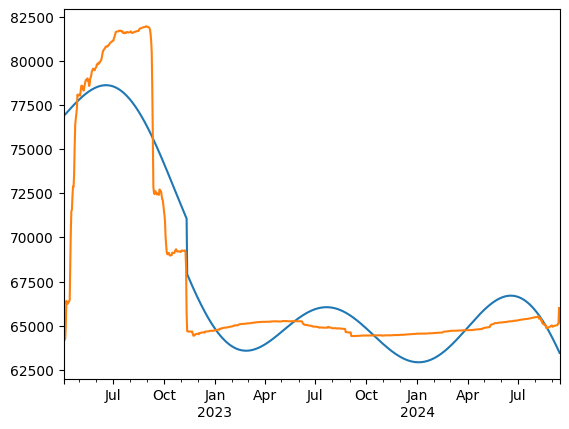

In [17]:
best_ff.predict(ff).plot()
aa["area"].plot()

In [18]:
aa.loc["2022-02-03":]

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-09-10,65029.254117,0
2024-09-11,65091.699226,0
2024-09-12,65105.927161,0
2024-09-13,66004.634331,0


In [19]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

,ru_holiday,ua_holiday,const,trend
2022-04-03,0,0,1.0,1.0
2022-04-04,0,0,1.0,2.0
2022-04-05,0,0,1.0,3.0
2022-04-06,0,0,1.0,4.0
2022-04-07,0,0,1.0,5.0
...,...,...,...,...
2024-09-10,0,0,1.0,892.0
2024-09-11,0,0,1.0,893.0
2024-09-12,0,0,1.0,894.0
2024-09-13,0,0,1.0,895.0


In [20]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packag

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  896
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -5907.544
Date:                Sun, 15 Sep 2024   AIC                          11835.087
Time:                        19:09:01   BIC                          11883.056
Sample:                    04-03-2022   HQIC                         11853.416
                         - 09-14-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1456      0.065     17.761      0.000       1.019       1.272
ar.L2         -1.1269      0.061    -18.577      0.000      -1.246      -1.008
ar.L3          1.0130      0.064     15.838      0.000       0.888       1.138
ar.L4         -0.0609      0.058     -1.044      0.297      -0.175       0.053
ma.L1         -0.4425      0.065     -6.797      0.000      -0.570      -0.315
ma.L2          0.6215      0.024     26.077      0.000       0.575       0.668
ma.L3         -0.5409      0.039    -13.979      0.000      -0.617      -0.465
ma.L4         -0.2181      0.030     -7.228      0.000      -0.277      -0.159
ma.L5         -0.2739      0.032     -8.661      0.000      -0.336      -0.212
sigma2      2.753e+04    256.796    107.191      0.000     2.7e+04     2.8e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.63   Jarque-Bera (JB):            119030.77
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                            -3.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        59.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-09-15,64467.197223,165.910428,64142.018759,64792.375686
2024-09-16,64061.891110,327.677501,63419.655009,64704.127211
2024-09-17,64132.422993,466.744481,63217.620620,65047.225366
2024-09-18,64044.451092,575.288650,62916.906057,65171.996128
2024-09-19,63890.397474,676.833413,62563.828361,65216.966587
...,...,...,...,...
2025-01-08,62671.094845,6658.106379,49621.446137,75720.743553
2025-01-09,62660.070702,6701.469897,49525.431061,75794.710343
2025-01-10,62668.518695,6744.686120,49449.176813,75887.860578
2025-01-11,62672.666534,6787.592786,49369.229132,75976.103937


In [22]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha /
     100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [23]:
country_area = {
    'Черногория': 14026,
    'Словения': 20253,
    'Северная Македония': 25333,
    'Албания': 28748,
    'Бельгия': 32528,
    'Молдавия': 33843,
    'Швейцария': 41290,
    'Нидерланды': 41526,
    'Дания': 42895,
    'Эстония': 45226,
    'Босния и Герцеговина': 51129,
    'Хорватия': 56542,
    'Латвия': 64589,
    'Литва': 65200,
    'Ирландия': 70273,
    'Чехия': 78866,
    'Австрия': 83858
}

In [24]:
max_idx = aa.iloc[-365-14:-14]['area'].idxmax()
max_val = round(aa.iloc[-365-14:-14]['area'].max()/1000, 1)

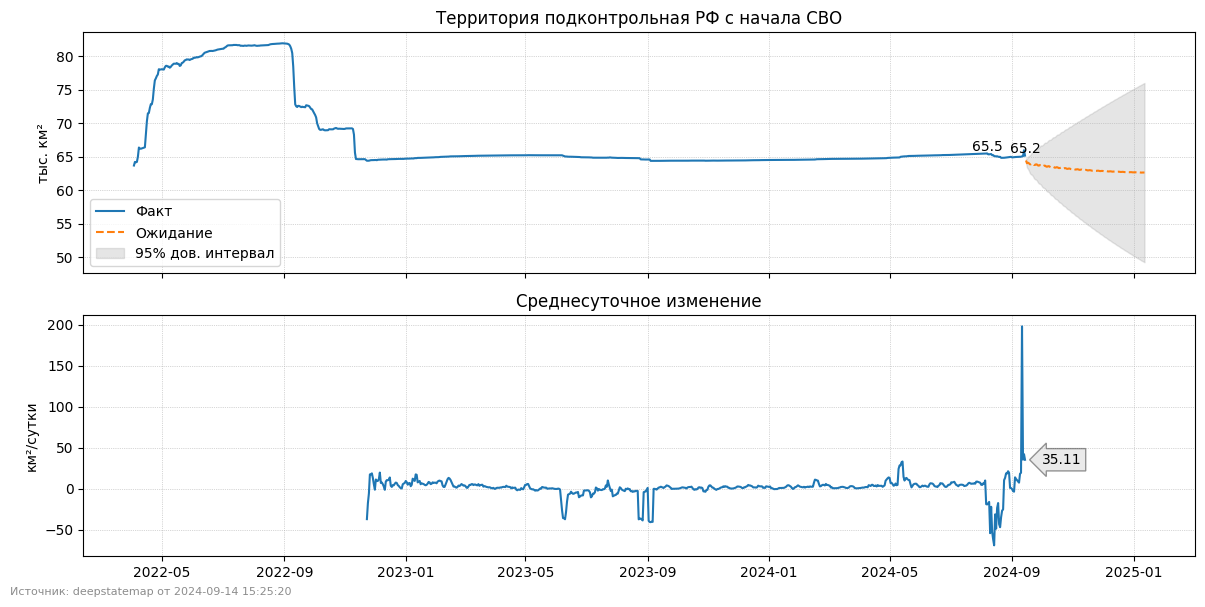

In [25]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)

ax.text(max_idx, max_val,
        f'{max_val:.1f}', ha='center', va='bottom')

ax.text(aa['area'].index.max(), aa['area'].iloc[-1] /
        1000, f'{aa['area'].iloc[-1]/1000:.1f}', ha='center', va='bottom')

ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = (
    aa.diff()["2022-11-23":].rolling(5, center=True,
                                     min_periods=3).mean()
)
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=16 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)